In [31]:
import os
import numpy as np
import pandas as pd

import re

import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

from gensim.models import Word2Vec

In [2]:
src_path = '/content/drive/MyDrive/Colab-Notebooks/nlp'

## Dataset

In [ ]:
os.chdir(src_path)
! pwd

#Download IMDB to the current folder
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# Unzip
!tar zxf aclImdb_v1.tar.gz
# aclImdb / train / unsup is unlabeled and removed
!rm -rf aclImdb/train/unsup
# Show IMDB dataset description
!cat aclImdb/README

In [4]:
from sklearn.datasets import load_files
train_review = load_files(os.path.join(src_path, 'aclImdb/train/'), encoding='utf-8')
x_train, y_train = train_review.data, train_review.target
#test_review = load_files(os.path.join(src_path, 'aclImdb/test/'), encoding='utf-8')
#x_test, y_test = test_review.data, test_review.target
# Display of the correspondence between 0, 1 of the label and the meaning
print(train_review.target_names)

['neg', 'pos']


In [ ]:
print("x_train type: {}".format(type(x_train)))
print("y_train type: {}".format(type(y_train)))

print(len(x_train))
print(len(y_train))

print("x : {}".format(x_train[0]))
print("y: {}".format(y_train[0]))

x_train type: <class 'list'>
y_train type: <class 'numpy.ndarray'>
25000
25000
x : Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty.
y: 1


## Example

In [ ]:
mini_dataset = \
  ["This movie is very good.",
  "This film is a good",
  "Very bad. Very, very bad."]

In [ ]:
vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b')
bow = (vectorizer.fit_transform(mini_dataset)).toarray()
display(bow)
#Put together in DataFrame
df = pd.DataFrame(bow, columns=vectorizer.get_feature_names())
display(df)

array([[0, 0, 0, 1, 1, 1, 1, 1],
       [1, 0, 1, 1, 1, 0, 1, 0],
       [0, 2, 0, 0, 0, 0, 0, 3]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,a,bad,film,good,is,movie,this,very
0,0,0,0,1,1,1,1,1
1,1,0,1,1,1,0,1,0
2,0,2,0,0,0,0,0,3


In [ ]:
#Specify the range of n-gram used in  ngram_range
vectorizer = CountVectorizer(ngram_range=(3, 3), token_pattern=r'(?u)\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,bad very very,film is a,is a good,is very good,movie is very,this film is,this movie is,very bad very,very very bad
0,0,0,0,1,1,0,1,0,0
1,0,1,1,0,0,1,0,0,0
2,1,0,0,0,0,0,0,1,1


# [Problem 1] Scratch implementation of BoW

In [ ]:
def bow(sentences, n_gram):
    if (type(sentences) is not list):
        raise Exception("sentences is not list") 
    
    if (type(n_gram) is not int):
        raise Exception("n_grams is not int") 

    feature_names = []
    cnt_array = np.empty((len(sentences), 0))

    for sentence_idx, sentence in enumerate(sentences):
        #preprocess each sentence
        sentence = sentence.lower().replace('!', '').split(' ')

        #create feature_names array and count up
        for i in range(0, len(sentence) - n_gram + 1):
            feature = ' '.join(sentence[i:i + n_gram])
            if (feature not in feature_names):
                feature_names.append(feature)
                cnt_array = np.append(cnt_array, np.zeros((len(sentences), 1)), axis=1)
            cnt_array[sentence_idx, feature_names.index(feature)] += 1
    
    return feature_names, cnt_array.astype(np.int)

In [ ]:
sentences = [
             'This movie is SOOOO funny!!!',
             'What a movie! I never',
             'best movie ever!!!!! this movie'
        ]

### scratch version

In [ ]:
feature_names, cnt_array = bow(sentences, 1)
df = pd.DataFrame(cnt_array, columns=feature_names)
display(df)

feature_names, cnt_array = bow(sentences, 2)
df = pd.DataFrame(cnt_array, columns=feature_names)
display(df)

,this,movie,is,soooo,funny,what,a,i,never,best,ever
0,1,1,1,1,1,0,0,0,0,0,0
1,0,1,0,0,0,1,1,1,1,0,0
2,1,2,0,0,0,0,0,0,0,1,1


,this movie,movie is,is soooo,soooo funny,what a,a movie,movie i,i never,best movie,movie ever,ever this
0,1,1,1,1,0,0,0,0,0,0,0
1,0,0,0,0,1,1,1,1,0,0,0
2,1,0,0,0,0,0,0,0,1,1,1


### Sklearn version

In [ ]:
vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b')
bow = (vectorizer.fit_transform(sentences)).toarray()
#Put together in DataFrame
df = pd.DataFrame(bow, columns=vectorizer.get_feature_names())
display(df)

vectorizer = CountVectorizer(ngram_range=(2, 2), token_pattern=r'(?u)\b\w+\b')
bow = (vectorizer.fit_transform(sentences)).toarray()
#Put together in DataFrame
df = pd.DataFrame(bow, columns=vectorizer.get_feature_names())
display(df)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,a,best,ever,funny,i,is,movie,never,soooo,this,what
0,0,0,0,1,0,1,1,0,1,1,0
1,1,0,0,0,1,0,1,1,0,0,1
2,0,1,1,0,0,0,2,0,0,1,0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,a movie,best movie,ever this,i never,is soooo,movie ever,movie i,movie is,soooo funny,this movie,what a
0,0,0,0,0,1,0,0,1,1,1,0
1,1,0,0,1,0,0,1,0,0,0,1
2,0,1,1,0,0,1,0,0,0,1,0


# [Problem 2] TF-IDF calculation

### example

In [ ]:
vectorizer = CountVectorizer(stop_words=["is"], token_pattern=r'\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,a,bad,film,good,movie,this,very
0,0,0,0,1,1,1,1
1,1,0,1,1,0,1,0
2,0,2,0,0,0,0,3


In [ ]:
# Download Stopword for the first time
stop_words = nltk.download('stopwords')
stop_words = stopwords.words('english')
print("stop word : {}".format(stop_words)) # 'i', 'me', 'my', ..
print("length: {}".format(len(stop_words)))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
stop word : ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all'

In [ ]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b', max_features = 5)
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,bad,good,is,this,very
0,0,1,1,1,1
1,0,1,1,1,0
2,2,0,0,0,3


### Vectorize the IMDB movie review dataset with TF-IDF

In [ ]:
MAX_FEATURES = 5000

tfidf_vectorizer = TfidfVectorizer(
    lowercase=True,
    analyzer='word',
    token_pattern=r'(?u)\b\w+\b',
    ngram_range=(1,1),
    norm='l2',
    stop_words=stop_words,
    max_features=MAX_FEATURES
)
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train).toarray()

print(tfidf_vectorizer.get_feature_names_out())
print(x_train_tfidf[:100])
print(x_train_tfidf.shape)

['0' '00' '000' ... 'zombie' 'zombies' 'zone']
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.14273931 0.         0.         ... 0.         0.         0.        ]]
(25000, 5000)


# [Problem 3] Learning using TF-IDF

In [ ]:
def compute_score(y_pred, y):
    print("Accuracy: {}".format(metrics.accuracy_score(y_pred=y_pred, y_true=y)))
    print("Precision: {}".format(metrics.precision_score(y_pred=y_pred, y_true=y)))
    print("Recall: {}".format(metrics.recall_score(y_pred=y_pred, y_true=y)))
    print("F1: {}".format(metrics.f1_score(y_pred=y_pred, y_true=y)))

In [ ]:
x_tr, x_val, y_tr, y_val = train_test_split(x_train_tfidf, y_train, test_size=0.25, random_state=5)

print(x_tr.shape)
print(x_val.shape)
print(y_tr.shape)
print(y_val.shape)

(18750, 5000)
(6250, 5000)
(18750,)
(6250,)


In [ ]:
model = LogisticRegression(max_iter=100)
model.fit(x_tr, y_tr)
y_pred = model.predict(x_val)
compute_score(y_pred, y_val)

Accuracy: 0.88848
Precision: 0.8738433066008636
Recall: 0.9077218840115348
F1: 0.8904604746188904


<h3>n_grams = (2, 5)</h3>

In [ ]:
MAX_FEATURES = 5000

tfidf_vectorizer = TfidfVectorizer(
    lowercase=True,
    analyzer='word',
    token_pattern=r'(?u)\b\w+\b',
    ngram_range=(2,5),
    norm='l2',
    stop_words=stop_words,
    max_features=MAX_FEATURES
)
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train).toarray()

print(tfidf_vectorizer.get_feature_names_out())
print(x_train_tfidf[:10])
print(x_train_tfidf.shape)

['0 10' '1 10' '1 2' ... 'zeta jones' 'zombi 3' 'zombie movie']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(25000, 5000)


In [ ]:
x_tr, x_val, y_tr, y_val = train_test_split(x_train_tfidf, y_train, test_size=0.25, random_state=5)

In [ ]:
model = LogisticRegression(max_iter=100)
model.fit(x_tr, y_tr)
y_pred = model.predict(x_val)
compute_score(y_pred, y_val)

Accuracy: 0.81904
Precision: 0.8055896805896806
Recall: 0.8404357577699455
F1: 0.8226438764309235


<h3>increase max_features size to 10000</h3>

In [ ]:
MAX_FEATURES = 10000

tfidf_vectorizer = TfidfVectorizer(
    lowercase=True,
    analyzer='word',
    token_pattern=r'(?u)\b\w+\b',
    ngram_range=(1, 1),
    norm='l2',
    stop_words=stop_words,
    max_features=MAX_FEATURES
)
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train).toarray()

print(tfidf_vectorizer.get_feature_names_out())
print(x_train_tfidf[:10])
print(x_train_tfidf.shape)

['0' '00' '000' ... 'zoom' 'zorro' 'zu']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(25000, 10000)


In [ ]:
x_tr, x_val, y_tr, y_val = train_test_split(x_train_tfidf, y_train, test_size=0.25, random_state=5)

In [ ]:
model = LogisticRegression(max_iter=100)
model.fit(x_tr, y_tr)
y_pred = model.predict(x_val)
compute_score(y_pred, y_val)

Accuracy: 0.89152
Precision: 0.875268817204301
Recall: 0.912848446010894
F1: 0.89366373902133


# [Problem 4] Scratch mounting of TF-IDF

In [ ]:
def tfidf_std(sentences, n_gram):
    feature_names, cnt_array = bow(sentences, n_gram)

    tfidf_array = np.zeros(cnt_array.shape).astype(np.float64)
    for d_idx, d in enumerate(cnt_array):
        for t_idx, t_cnt in enumerate(d):
            tf = (t_cnt / np.sum(d)).astype(np.float64)
            idf = np.log(cnt_array.shape[0] / np.count_nonzero(cnt_array[:, t_idx])).astype(np.float64)
            tfidf_array[d_idx, t_idx] = tf * idf
    
    return feature_names, tfidf_array

In [ ]:
def tfidf_sklearn(sentences, n_gram):
    feature_names, cnt_array = bow(sentences, n_gram)

    tfidf_array = np.zeros(cnt_array.shape).astype(np.float64)
    for d_idx, d in enumerate(cnt_array):
        for t_idx, t_cnt in enumerate(d):
            tf = t_cnt.astype(np.float64)
            idf = (np.log((1 + cnt_array.shape[0]) / (1 + np.count_nonzero(cnt_array[:, t_idx]))) + 1).astype(np.float64)
            tfidf_array[d_idx, t_idx] = tf * idf
    
    return feature_names, tfidf_array

In [ ]:
sentences = [
             'This movie is SOOOO funny!!!',
             'What a movie! I never',
             'best movie ever!!!!! this movie'
        ]

### scratch test

In [ ]:
feature_names_std, tfidf_array_std = tfidf_std(sentences, 1)

print("feature_names shape: {}\n{}".format(len(feature_names_std), feature_names_std))
print("\n\ntfidf shape: {}\n{}".format(tfidf_array_std.shape, tfidf_array_std))

feature_names shape: 11
['this', 'movie', 'is', 'soooo', 'funny', 'what', 'a', 'i', 'never', 'best', 'ever']


tfidf shape: (3, 11)
[[0.08109302 0.         0.21972246 0.21972246 0.21972246 0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.21972246
  0.21972246 0.21972246 0.21972246 0.         0.        ]
 [0.08109302 0.         0.         0.         0.         0.
  0.         0.         0.         0.21972246 0.21972246]]


In [ ]:
feature_names_sklearn, tfidf_array_sklearn = tfidf_sklearn(sentences, 1)

print("feature_names shape: {}\n{}".format(len(feature_names_sklearn), feature_names_sklearn))
print("\n\ntfidf shape: {}\n{}".format(tfidf_array_sklearn.shape, tfidf_array_sklearn))

feature_names shape: 11
['this', 'movie', 'is', 'soooo', 'funny', 'what', 'a', 'i', 'never', 'best', 'ever']


tfidf shape: (3, 11)
[[1.28768207 1.         1.69314718 1.69314718 1.69314718 0.
  0.         0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         1.69314718
  1.69314718 1.69314718 1.69314718 0.         0.        ]
 [1.28768207 2.         0.         0.         0.         0.
  0.         0.         0.         1.69314718 1.69314718]]


### verify with sklearn instance

In [ ]:
tfidf_vectorizer = TfidfVectorizer(
    lowercase=True,
    analyzer='word',
    token_pattern=r'(?u)\b\w+\b',
    ngram_range=(1,1),
    norm=None,
)

tfidf_array = tfidf_vectorizer.fit_transform(sentences).toarray()

print("feature_names shape: {}\n{}".format(len(tfidf_vectorizer.get_feature_names_out()), tfidf_vectorizer.get_feature_names_out()))
print("\n\ntfidf shape: {}\n{}".format(tfidf_array.shape, tfidf_array))

feature_names shape: 11
['a' 'best' 'ever' 'funny' 'i' 'is' 'movie' 'never' 'soooo' 'this' 'what']


tfidf shape: (3, 11)
[[0.         0.         0.         1.69314718 0.         1.69314718
  1.         0.         1.69314718 1.28768207 0.        ]
 [1.69314718 0.         0.         0.         1.69314718 0.
  1.         1.69314718 0.         0.         1.69314718]
 [0.         1.69314718 1.69314718 0.         0.         0.
  2.         0.         0.         1.28768207 0.        ]]


# [Problem 5] Corpus pretreatment

### examples

In [7]:
sentences = [['this', 'movie', 'is', 'very', 'good'], ['this', 'film', 'is', 'a', 'good'], ['very', 'bad', 'very', 'very', 'bad']]

model = Word2Vec(min_count=1, size=10) # Set the number of dimensions to 10
model.build_vocab(sentences) # Preparation
model.train(sentences, total_examples=model.corpus_count, epochs=model.iter) #Learning

print("List of vocabulary : {}".format(model.wv.vocab.keys()))
for vocab in model.wv.vocab.keys():
    print("Vector of {}: \n{}".format(vocab, model.wv[vocab]))

List of vocabulary : dict_keys(['this', 'movie', 'is', 'very', 'good', 'film', 'a', 'bad'])
Vector of this: 
[ 0.02940114  0.01218737  0.04908844  0.00481046  0.00307057  0.02048454
 -0.01472978 -0.02223788 -0.03460115 -0.01494917]
Vector of movie: 
[-0.02529234 -0.04579966  0.02190255 -0.02427819 -0.0085281  -0.01913026
 -0.04795958  0.03708158 -0.04434683 -0.03708117]
Vector of is: 
[-0.016098   -0.04396301 -0.00054249  0.0427971  -0.01027839 -0.04971489
  0.00697997 -0.00441074  0.01632939  0.02288274]
Vector of very: 
[ 0.02672385  0.03696061 -0.04232404 -0.02159391  0.00127477 -0.01312801
 -0.00759578  0.01066592 -0.00508885 -0.00563211]
Vector of good: 
[ 0.04223053 -0.01497705  0.02276838  0.01060793  0.03302906  0.00885725
  0.04556049 -0.04088947  0.03805811 -0.01487571]
Vector of film: 
[ 0.04732336 -0.02914096 -0.0032779   0.00761514  0.04948122  0.03182923
  0.00582118 -0.0313409   0.04913603 -0.00731568]
Vector of a: 
[ 0.00344742 -0.03122339 -0.03841421  0.00823043  0.018

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """


In [8]:
model.wv.most_similar(positive="good", topn=3)

[('film', 0.8165238499641418),
 ('this', 0.22223302721977234),
 ('is', 0.05061196908354759)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


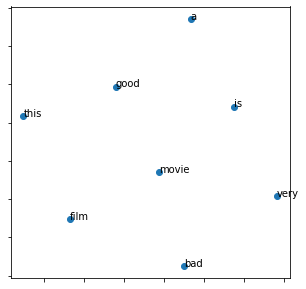

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

vocabs = model.wv.vocab.keys()
tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
vectors_tsne = tsne_model.fit_transform(model[vocabs])
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
for i, word in enumerate(list(vocabs)):
    plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

##  pre-process for IMDB corpus

In [43]:
def word_tokenizer(dataset):
    return [re.findall(r'\b\w+\b', corpus.lower()) for corpus in dataset]

In [33]:
mini_dataset = \
  ["This movie is very good.",
  "This film is a good",
  "Very bad. Very, very bad."]

In [44]:
tokens = word_tokenizer(mini_dataset)

print(tokens)

[['this', 'movie', 'is', 'very', 'good'], ['this', 'film', 'is', 'a', 'good'], ['very', 'bad', 'very', 'very', 'bad']]


In [47]:
x_train_tokens = word_tokenizer(x_train)

print(x_train_tokens[:5])
print(len(x_train_tokens))

[['zero', 'day', 'leads', 'you', 'to', 'think', 'even', 're', 'think', 'why', 'two', 'boys', 'young', 'men', 'would', 'do', 'what', 'they', 'did', 'commit', 'mutual', 'suicide', 'via', 'slaughtering', 'their', 'classmates', 'it', 'captures', 'what', 'must', 'be', 'beyond', 'a', 'bizarre', 'mode', 'of', 'being', 'for', 'two', 'humans', 'who', 'have', 'decided', 'to', 'withdraw', 'from', 'common', 'civility', 'in', 'order', 'to', 'define', 'their', 'own', 'mutual', 'world', 'via', 'coupled', 'destruction', 'br', 'br', 'it', 'is', 'not', 'a', 'perfect', 'movie', 'but', 'given', 'what', 'money', 'time', 'the', 'filmmaker', 'and', 'actors', 'had', 'it', 'is', 'a', 'remarkable', 'product', 'in', 'terms', 'of', 'explaining', 'the', 'motives', 'and', 'actions', 'of', 'the', 'two', 'young', 'suicide', 'murderers', 'it', 'is', 'better', 'than', 'elephant', 'in', 'terms', 'of', 'being', 'a', 'film', 'that', 'gets', 'under', 'our', 'rationalistic', 'skin', 'it', 'is', 'a', 'far', 'far', 'better', 

# [Problem 6] Learning Word2Vec

In [49]:
model = Word2Vec(min_count=1, size=10)
model.build_vocab(x_train_tokens)
model.train(x_train_tokens, total_examples=model.corpus_count, epochs=model.iter)

print("List of vocabulary : {}".format(len(model.wv.vocab.keys())))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  This is separate from the ipykernel package so we can avoid doing imports until


List of vocabulary : 74891


# [Problem 7] (Advance assignment) Vector visualization

In [ ]:
vocabs = model.wv.vocab.keys()
tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
vectors_tsne = tsne_model.fit_transform(model[vocabs])

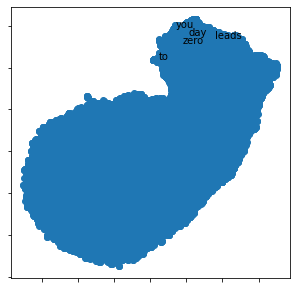

In [54]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
for i, word in enumerate(list(vocabs)[:5]):
    plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

In [57]:
model.wv.most_similar(positive="outstanding", topn=10)

[('excellent', 0.9678527116775513),
 ('fantastic', 0.9676470160484314),
 ('superb', 0.9593614339828491),
 ('exceptional', 0.958545982837677),
 ('brilliant', 0.954558789730072),
 ('wonderful', 0.9493317008018494),
 ('delightful', 0.9471040964126587),
 ('katzman', 0.9399738311767578),
 ('magnificent', 0.9362589716911316),
 ('splendid', 0.9333320260047913)]

In [58]:
model.wv.most_similar(positive="horrible", topn=10)

[('terrible', 0.9774766564369202),
 ('awful', 0.9588446021080017),
 ('bad', 0.9432796239852905),
 ('good', 0.9278640747070312),
 ('lame', 0.923764169216156),
 ('ridiculous', 0.9237207174301147),
 ('boring', 0.9202768206596375),
 ('yes', 0.9197544455528259),
 ('predictable', 0.9152495265007019),
 ('disappointing', 0.914724588394165)]